In [9]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [12]:
price_indicator = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price_indicators.parquet")


In [13]:
reddit_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/9.reddit_sentiment_processed.parquet.gzip")
reddit_results.rename(columns={"date": "date_hour"}, inplace=True)
reddit_results.set_index("date_hour", inplace=True)

reddit_results

,total_sentiment,average_sentiment
date_hour,,
2021-01-01 00:00:00,0.2966,0.015611
2021-01-01 01:00:00,1.6673,0.049038
2021-01-01 02:00:00,0.4588,0.021848
2021-01-01 03:00:00,-0.4329,-0.020614
2021-01-01 04:00:00,0.0000,0.000000
...,...,...
2024-12-31 19:00:00,0.0000,0.000000
2024-12-31 20:00:00,0.0000,0.000000
2024-12-31 21:00:00,0.0000,0.000000


In [14]:
xgb_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/8.xgb_result.parquet")
xgb_results.set_index('date_hour', inplace=True)
xgb_results = xgb_results.drop("index", axis=1)

xgb_results

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal
date_hour,,,,,,,,,,,,
2024-01-01 00:00:00,0.362963,0.0,-0.125926,0.0,-0.159259,0.0,0.200000,-0.016667,0.016667,-0.033333,-0.00138510658277772561,0
2024-01-01 01:00:00,-0.300000,0.0,0.000000,0.0,0.200000,1.0,-0.020000,-0.076667,0.033333,-0.032500,-0.00072877729976255965,-1
2024-01-01 02:00:00,-0.233333,0.0,-0.066667,0.0,0.333333,3.0,0.006667,-0.104444,-0.001111,-0.015000,-0.00592857478944149061,-1
2024-01-01 03:00:00,0.250000,0.0,-0.500000,0.0,-0.175000,4.0,-0.085000,0.055833,0.043333,0.021458,0.00009466559378993700,0
2024-01-01 04:00:00,0.000000,0.0,-0.450000,0.0,0.150000,2.0,-0.060000,0.100000,0.027500,0.045833,0.00501680155236878220,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,-0.00630797378946472641,-1
2024-12-31 20:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.00285821334903388110,-1
2024-12-31 21:00:00,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.000000,0.000000,0.000000,0.000000,-0.00414167075852351572,-1


In [15]:
rfr_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/8.rfr_result.parquet")
rfr_results

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal
26270,2024-01-01 00:00:00,0.362963,0.0,-0.125926,0.0,-0.159259,0.0,0.200000,-0.016667,0.016667,-0.033333,-0.00138510658277772561,NaN
26271,2024-01-01 01:00:00,-0.300000,0.0,0.000000,0.0,0.200000,1.0,-0.020000,-0.076667,0.033333,-0.032500,-0.00072877729976255965,NaN
26272,2024-01-01 02:00:00,-0.233333,0.0,-0.066667,0.0,0.333333,3.0,0.006667,-0.104444,-0.001111,-0.015000,-0.00592857478944149061,NaN
26273,2024-01-01 03:00:00,0.250000,0.0,-0.500000,0.0,-0.175000,4.0,-0.085000,0.055833,0.043333,0.021458,0.00009466559378993700,NaN
26274,2024-01-01 04:00:00,0.000000,0.0,-0.450000,0.0,0.150000,2.0,-0.060000,0.100000,0.027500,0.045833,0.00501680155236878220,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35049,2024-12-31 19:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,-0.00630797378946472641,NaN
35050,2024-12-31 20:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.00285821334903388110,NaN
35051,2024-12-31 21:00:00,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.000000,0.000000,0.000000,0.000000,-0.00414167075852351572,NaN
35052,2024-12-31 22:00:00,0.000000,0.0,0.000000,0.0,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.00093253585439578110,NaN


In [16]:
target_col = "target"

start_date = pd.to_datetime("2024-01-01 00:00:00")
end_date = pd.to_datetime("2024-12-31 23:00:00")

# Training: 2021-01-01 to 2022-12-31
# price_indicator.set_index('Timestamp', inplace=True)
price_indicator.index.rename('date_hour', inplace=True)

# Filter rows starting from 2024-01-01 00:00
price_indicator_2024 = price_indicator.loc[start_date:end_date]

price_indicator_2024

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,rsi_14,atr_7,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,42652.0,42671.0,42569.0,42596.0,5.454452,-0.001385,-0.001008,165832.144886,42571.6,42540.3,...,57.808423,184.285112,198.428807,208.321905,42694.689248,42540.3,42385.910752,42794.749591,42428.05,42061.350409
2024-01-01 01:00:00,42600.0,42643.0,42500.0,42537.0,33.104355,-0.000729,-0.001385,165799.040531,42589.2,42528.8,...,54.964723,178.387239,194.469607,205.211338,42664.153758,42528.8,42393.446242,42805.195764,42437.85,42070.504236
2024-01-01 02:00:00,42537.0,42640.0,42506.0,42506.0,46.611812,-0.005929,-0.000729,165752.428719,42575.4,42529.3,...,53.476227,172.046205,190.150349,201.820322,42664.275701,42529.3,42394.324299,42801.283246,42454.80,42108.316754
2024-01-01 03:00:00,42506.0,42563.0,42096.0,42254.0,126.372266,0.000095,-0.005929,165626.056453,42506.4,42511.2,...,43.227930,214.182461,209.925324,214.447926,42720.166600,42511.2,42302.233400,42781.350675,42462.95,42144.549325
2024-01-01 04:00:00,42246.0,42332.0,42072.0,42258.0,66.348207,0.005017,0.000095,165692.404660,42430.2,42491.4,...,43.413304,220.727824,213.502087,216.617072,42749.322779,42491.4,42233.477221,42771.696518,42467.30,42162.903482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,49.600999,787.401340,594.021005,490.327871,95801.067876,94516.7,93232.332124,95433.425204,94002.90,92572.374796
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,42.325843,783.344006,605.805219,503.121782,95876.395307,94461.6,93046.804693,95435.711991,93998.40,92561.088009
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,46.155291,734.437720,594.033418,500.163602,95898.271810,94421.0,92943.728190,95434.444994,94007.25,92580.055006


In [ ]:
price_indicator_2024.index = pd.to_datetime(price_indicator_2024.index)
xgb_results.index = pd.to_datetime(xgb_results.index)
reddit_results.index = pd.to_datetime(reddit_results.index)

# Merge the DataFrames on the index (date_hour)
merged_df = pd.concat([price_indicator_2024, xgb_results, reddit_results], axis=1)

# Drop any rows with missing values (optional, if needed)
merged_df.dropna(inplace=True)

# Verify the merged DataFrame
merged_df.drop("target",axis=1)
merged_df

                        open     high      low    close      volume  \
date_hour                                                             
2024-01-01 00:00:00  42652.0  42671.0  42569.0  42596.0    5.454452   
2024-01-01 01:00:00  42600.0  42643.0  42500.0  42537.0   33.104355   
2024-01-01 02:00:00  42537.0  42640.0  42506.0  42506.0   46.611812   
2024-01-01 03:00:00  42506.0  42563.0  42096.0  42254.0  126.372266   
2024-01-01 04:00:00  42246.0  42332.0  42072.0  42258.0   66.348207   

                     return_forward    return            obv    sma_5  \
date_hour                                                               
2024-01-01 00:00:00       -0.001385 -0.001008  165832.144886  42571.6   
2024-01-01 01:00:00       -0.000729 -0.001385  165799.040531  42589.2   
2024-01-01 02:00:00       -0.005929 -0.000729  165752.428719  42575.4   
2024-01-01 03:00:00        0.000095 -0.005929  165626.056453  42506.4   
2024-01-01 04:00:00        0.005017  0.000095  165692.404660  42

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal,total_sentiment,average_sentiment
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,42652.0,42671.0,42569.0,42596.0,5.454452,-0.001385,-0.001008,165832.144886,42571.6,42540.3,...,-0.159259,0.0,0.200000,-0.016667,0.016667,-0.033333,-0.00138510658277772561,0.0,0.0000,0.000000
2024-01-01 01:00:00,42600.0,42643.0,42500.0,42537.0,33.104355,-0.000729,-0.001385,165799.040531,42589.2,42528.8,...,0.200000,1.0,-0.020000,-0.076667,0.033333,-0.032500,-0.00072877729976255965,-1.0,0.0000,0.000000
2024-01-01 02:00:00,42537.0,42640.0,42506.0,42506.0,46.611812,-0.005929,-0.000729,165752.428719,42575.4,42529.3,...,0.333333,3.0,0.006667,-0.104444,-0.001111,-0.015000,-0.00592857478944149061,-1.0,0.6544,0.081800
2024-01-01 03:00:00,42506.0,42563.0,42096.0,42254.0,126.372266,0.000095,-0.005929,165626.056453,42506.4,42511.2,...,-0.175000,4.0,-0.085000,0.055833,0.043333,0.021458,0.00009466559378993700,0.0,0.0000,0.000000
2024-01-01 04:00:00,42246.0,42332.0,42072.0,42258.0,66.348207,0.005017,0.000095,165692.404660,42430.2,42491.4,...,0.150000,2.0,-0.060000,0.100000,0.027500,0.045833,0.00501680155236878220,0.0,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,-0.00630797378946472641,-1.0,0.0000,0.000000
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.00285821334903388110,-1.0,0.0000,0.000000
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0.000000,3.0,0.000000,0.000000,0.000000,0.000000,-0.00414167075852351572,-1.0,0.0000,0.000000


# Statistical Feature Selection

In [18]:
train_start_date = pd.to_datetime("2024-01-01 00:00:00")
train_end_date = pd.to_datetime("2024-11-30 23:00:00")

test_start_date = pd.to_datetime("2024-12-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")


# Filter rows starting from 2024-01-01 00:00
price_indicator_train = merged_df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = merged_df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal,total_sentiment,average_sentiment
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-12-01 00:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.300000,4.0,0.020000,0.068333,0.082083,0.089792,-0.00208571132095050327,0.0,0.8607,0.095633
2024-12-01 01:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.800000,1.0,0.160000,0.090000,0.113333,0.100000,-0.00344185756324803211,1.0,0.0000,0.000000
2024-12-01 02:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.700000,0.0,0.160000,0.090000,0.113333,0.100000,0.00546755984056428560,1.0,0.8910,0.089100
2024-12-01 03:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.266667,3.0,0.126667,0.076667,0.105000,0.107222,0.00175380336647226080,1.0,0.0000,0.000000
2024-12-01 04:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.000000,2.0,0.000000,0.113333,0.110833,0.124167,-0.00175073292517429634,1.0,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,-0.00630797378946472641,-1.0,0.0000,0.000000
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.00285821334903388110,-1.0,0.0000,0.000000
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0.000000,3.0,0.000000,0.000000,0.000000,0.000000,-0.00414167075852351572,-1.0,0.0000,0.000000


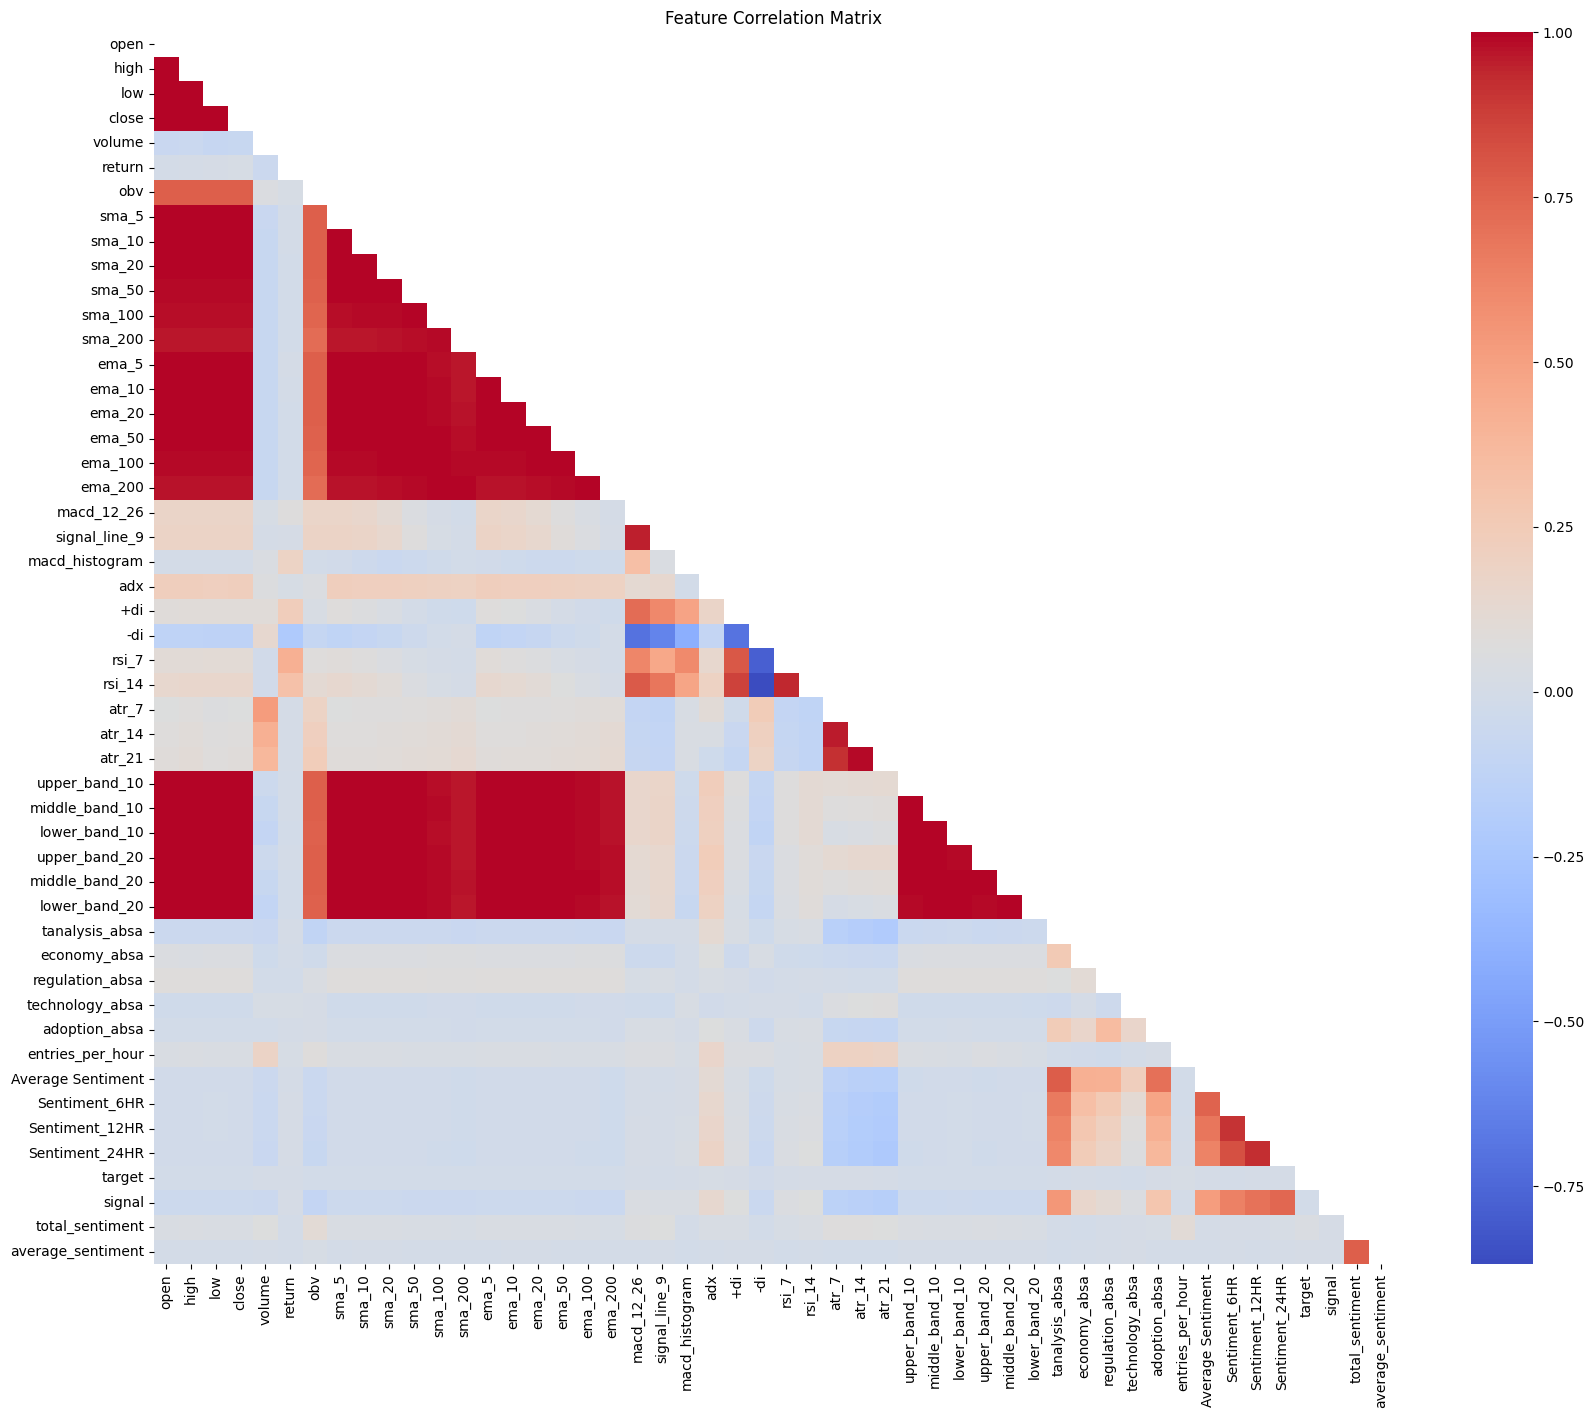

In [19]:
X = price_indicator_train_X
y = price_indicator_train_Y


plt.figure(figsize=(20, 16))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()



In [20]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
def remove_correlated_features(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

X_uncorrelated = remove_correlated_features(X)
print(f"Features reduced from {X.shape[1]} to {X_uncorrelated.shape[1]}")

# Feature importance using univariate selection
k_best_features = 15  # Select top 15 features
selector = SelectKBest(f_regression, k=k_best_features)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Top features selected:", selected_features.tolist())
selected_features

Features reduced from 50 to 23
Top features selected: ['obv', 'sma_20', 'sma_100', 'sma_200', 'ema_100', 'ema_200', 'adx', '-di', 'lower_band_10', 'lower_band_20', 'technology_absa', 'adoption_absa', 'entries_per_hour', 'target', 'total_sentiment']


Index(['obv', 'sma_20', 'sma_100', 'sma_200', 'ema_100', 'ema_200', 'adx',
       '-di', 'lower_band_10', 'lower_band_20', 'technology_absa',
       'adoption_absa', 'entries_per_hour', 'target', 'total_sentiment'],
      dtype='object')

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[selected_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (8735, 12, 15)
y shape: (8735, 1)
Total sequences: 8735
Training sequences: 7861
Testing sequences: 874


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100


2025-04-10 14:34:19.213640: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0240 - val_loss: 0.0022
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 9/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 11/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 12/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

array([[-5.63632557e-03],
       [-2.13478133e-03],
       [-3.09829391e-03],
       [-4.25760169e-03],
       [-3.62054724e-03],
       [-3.67843802e-03],
       [-2.57694814e-03],
       [-4.49029496e-03],
       [-1.76744559e-03],
       [-4.61304141e-03],
       [-1.37654017e-03],
       [-4.05523460e-04],
       [-1.96544593e-03],
       [-2.06808164e-03],
       [-2.00415892e-03],
       [-1.06169761e-03],
       [-1.73356547e-03],
       [-2.66234856e-03],
       [-2.95358873e-03],
       [-1.76396139e-03],
       [-3.83967883e-03],
       [-1.85782812e-03],
       [-2.36122054e-03],
       [-1.81152346e-03],
       [ 6.81362522e-04],
       [-1.39016379e-03],
       [ 1.22821308e-03],
       [-1.84800231e-03],
       [-3.69280134e-03],
       [-3.26087233e-03],
       [-3.60927451e-03],
       [-1.52255758e-03],
       [-1.89127459e-03],
       [-1.40532525e-03],
       [-1.53159257e-03],
       [-4.83743097e-05],
       [-6.35592558e-04],
       [-1.67727086e-03],
       [-7.1

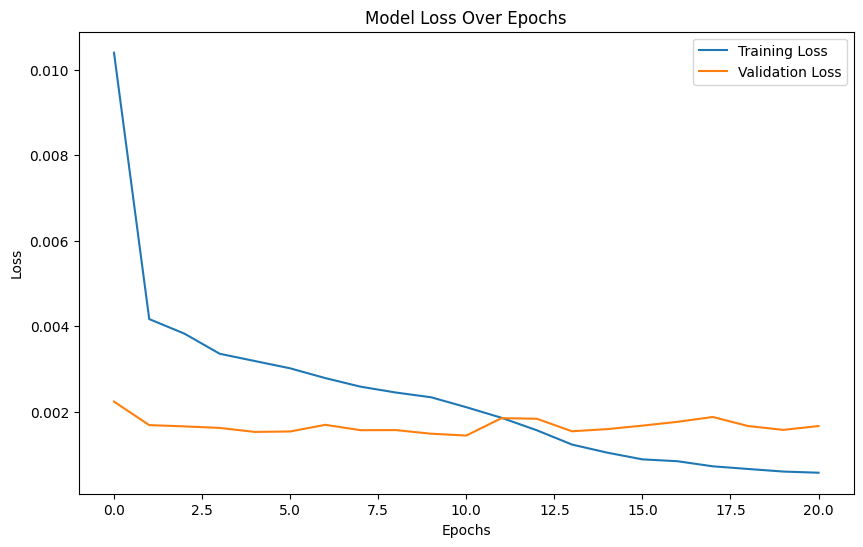

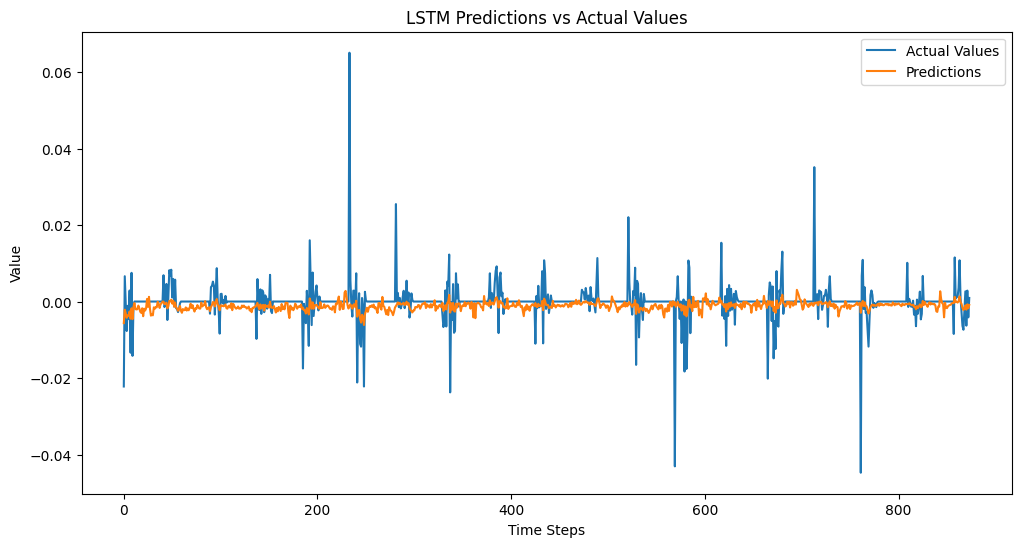

In [23]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [24]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)


In [25]:
model.save('sequential_selection_lstm_model.keras')  # HDF5 format


In [26]:
y_test

array([[0.18437009],
       [0.42011124],
       [0.36073643],
       [0.30295387],
       [0.35691313],
       [0.32844425],
       [0.389597  ],
       [0.25654981],
       [0.42738516],
       [0.24991248],
       [0.35784262],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.42223639],
       [0.35422034],
       [0.36199136],
       [0.40366289],
       [0.32653853],
       [0.37626245],
       [0.433

In [27]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)
results_df


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,Actual,Predicted
2024-11-25 14:00:00,-0.022214,-0.006155
2024-11-25 15:00:00,0.006615,-0.005592
2024-11-25 16:00:00,-0.000646,-0.005923
2024-11-25 17:00:00,-0.007712,-0.006384
2024-11-25 18:00:00,-0.001113,-0.006206
...,...,...
2024-12-31 19:00:00,0.002666,-0.003658
2024-12-31 20:00:00,-0.006308,-0.003888
2024-12-31 21:00:00,0.002858,-0.003629
2024-12-31 22:00:00,-0.004142,-0.003792


In [38]:
stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: -1 if x > 0.00001 else (1 if x < -0.00001 else 0))
stat_signal_result_df

,Predicted,signal
2024-11-25 14:00:00,-0.016023,1
2024-11-25 15:00:00,0.000898,-1
2024-11-25 16:00:00,-0.001453,1
2024-11-25 17:00:00,-0.005991,1
2024-11-25 18:00:00,-0.001288,1
...,...,...
2024-12-31 19:00:00,0.000277,-1
2024-12-31 20:00:00,-0.003925,1
2024-12-31 21:00:00,0.000137,-1
2024-12-31 22:00:00,-0.002100,1


Overall Annual Return: 360.34%
Overall Annual Sharpe Ratio: 3.1005
Maximum Drawdown: -7.85 %
Alpha: 4.308
Beta: 0.1237

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       3.603412    0.539304     0.123743      1.669382       3.100492


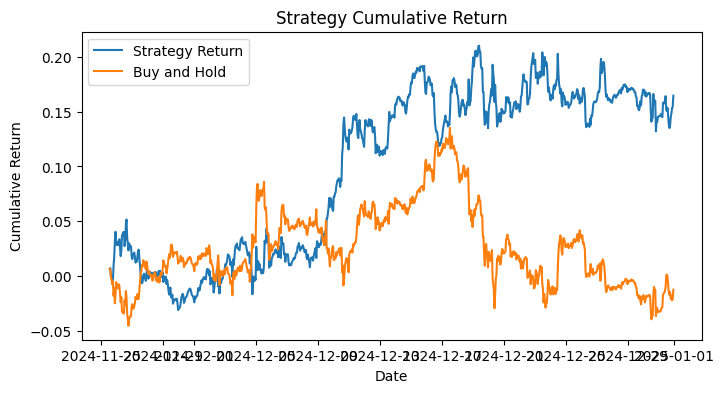

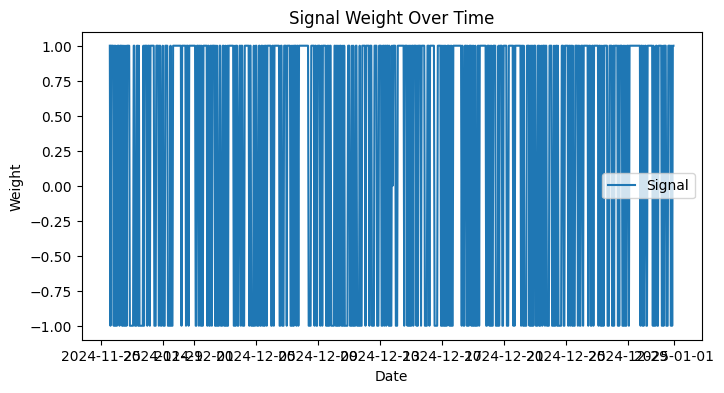

In [39]:
run_backtest(stat_signal_result_df)

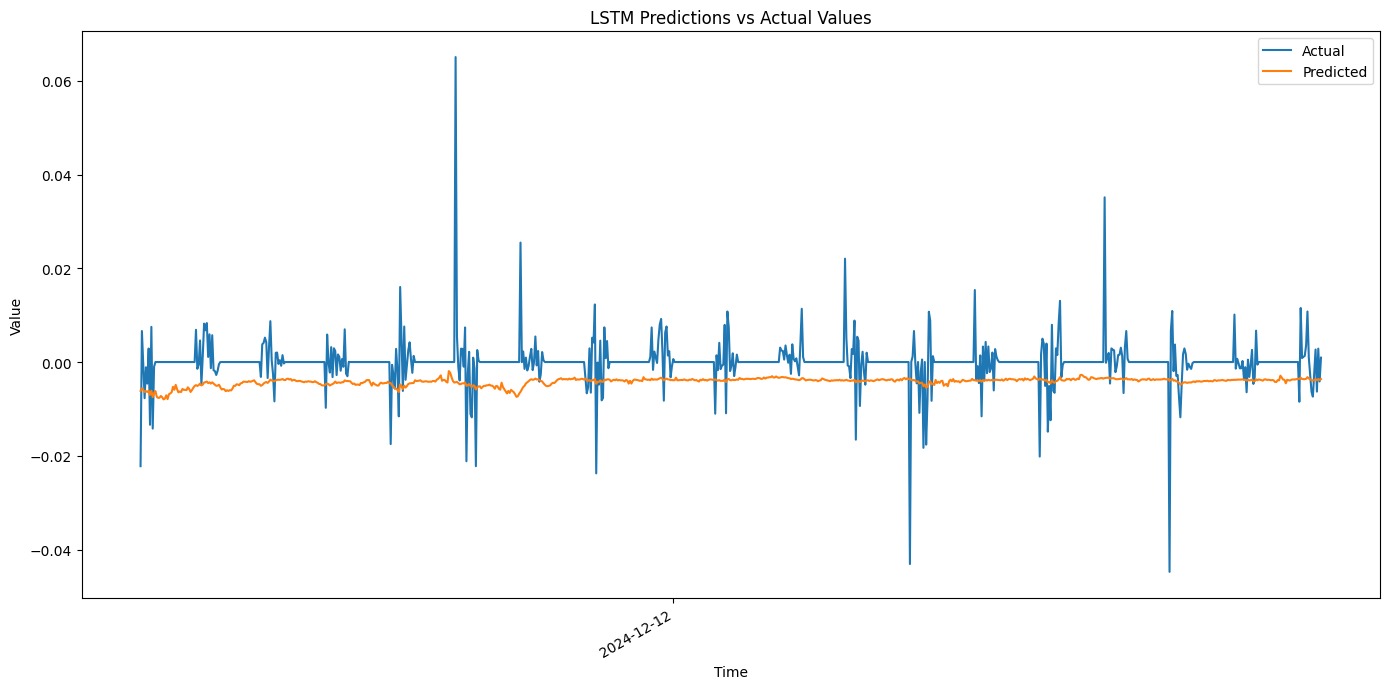

In [30]:
# Now you can plot with proper time indexes
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted')

# Format x-axis if using DatetimeIndex
if isinstance(results_df.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()

plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Sequential Feature Selection

In [31]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Select features that are most important for predicting time series patterns
sfs = SequentialFeatureSelector(
    LinearRegression(), 
    n_features_to_select=15,
    direction='forward',
    cv=5,
)
X_selected = sfs.fit_transform(X, y)
selected_feature_names = X.columns[sfs.get_support()]

# Use these features for LSTM model
lstm_features = selected_feature_names


In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[lstm_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (8735, 12, 15)
y shape: (8735, 1)
Total sequences: 8735
Training sequences: 7861
Testing sequences: 874


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0183 - val_loss: 0.0020
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 9/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 10/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 11/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 12/100
197/197 ━━━━━━━━━━━━━━━━━━━━

array([[-1.60228331e-02],
       [ 8.98460508e-04],
       [-1.45336112e-03],
       [-5.99101465e-03],
       [-1.28772855e-03],
       [-3.49095231e-03],
       [ 2.67810246e-05],
       [-9.04972851e-03],
       [ 3.13658500e-03],
       [-9.22907516e-03],
       [ 4.66248533e-03],
       [ 8.11115373e-03],
       [-1.36910519e-03],
       [-9.63173108e-04],
       [-1.89198530e-03],
       [ 1.51626428e-03],
       [-1.11632294e-03],
       [-5.80238085e-03],
       [-4.75664996e-03],
       [ 2.40498222e-03],
       [-8.66331253e-03],
       [ 2.75907776e-04],
       [-2.54250597e-04],
       [ 2.79599772e-04],
       [ 8.32382683e-03],
       [-4.13592585e-04],
       [ 7.82640837e-03],
       [-1.65221794e-03],
       [-9.33426991e-03],
       [-1.64200936e-03],
       [-3.57547449e-03],
       [ 3.42105725e-03],
       [ 1.46102300e-03],
       [ 7.06448278e-04],
       [ 1.08686936e-05],
       [ 5.08393254e-03],
       [ 1.50623790e-03],
       [-2.38628802e-03],
       [-2.7

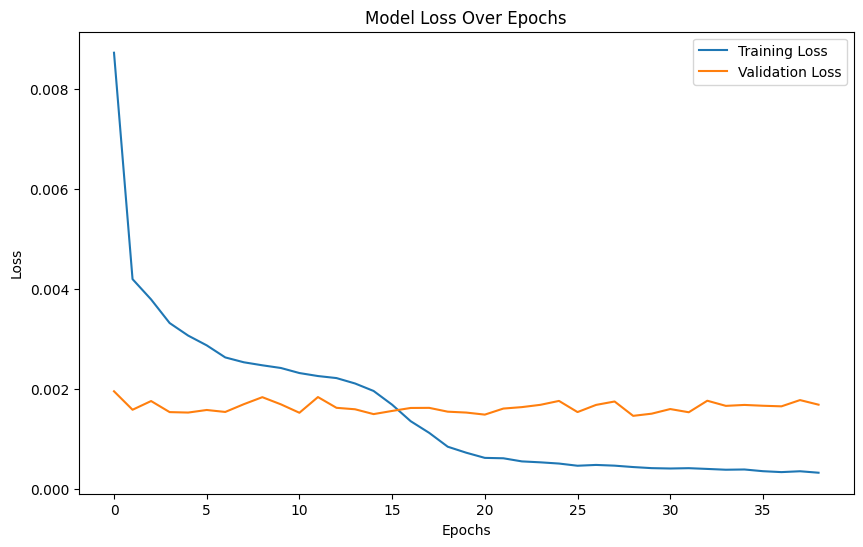

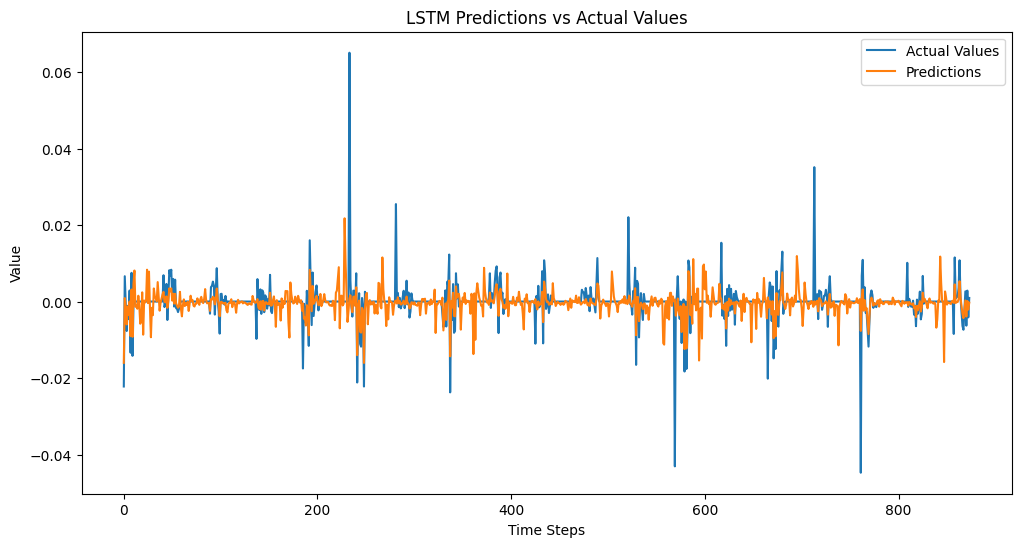

In [34]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [35]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)

model.save('stat_features_selection_lstm_model.keras')  # HDF5 format


In [40]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: -1 if x > 0.0001 else (1 if x < -0.0001 else 0))
stat_signal_result_df

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,Predicted,signal
2024-11-25 14:00:00,-0.016023,1
2024-11-25 15:00:00,0.000898,-1
2024-11-25 16:00:00,-0.001453,1
2024-11-25 17:00:00,-0.005991,1
2024-11-25 18:00:00,-0.001288,1
...,...,...
2024-12-31 19:00:00,0.000277,-1
2024-12-31 20:00:00,-0.003925,1
2024-12-31 21:00:00,0.000137,-1
2024-12-31 22:00:00,-0.002100,1


Overall Annual Return: 216.02%
Overall Annual Sharpe Ratio: 2.4702
Maximum Drawdown: -10.1 %
Alpha: 2.6078
Beta: 0.1288

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       2.160155    0.520628     0.128845      1.283193       2.470159


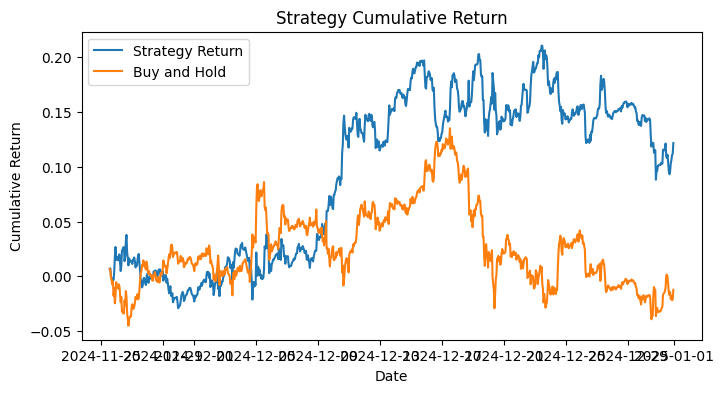

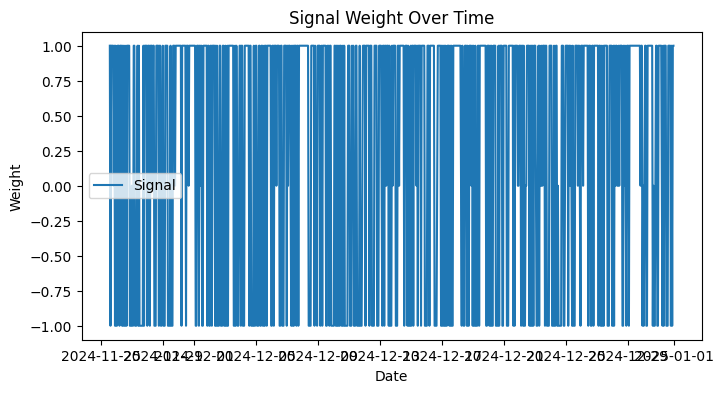

In [41]:
run_backtest(stat_signal_result_df)